# notebooks/eda.ipynb:
- Visualizations and descriptive stats.
- Missingness analysis.
- Correlation heatmaps, scatterplots, outlier checks.
- Exploratory lag analysis (ACF/PACF, lag vs. target plots).

## Loading data

In [1]:
# Basic
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

# Outlier detection
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

# Time-series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Display
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Path to your **single dataset**
PATH_DATA = "../data/processed/merged/players_transfer_outcomes.csv"

RANDOM_STATE = 42
N_SPLITS     = 5

# Ensure the file exists
if not os.path.exists(PATH_DATA):
    raise FileNotFoundError(f"Missing required file: {PATH_DATA} — Please generate it first.")

# Load the dataset
df = pd.read_csv(PATH_DATA)

print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (4829, 50)


,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name,player_name_norm,PreMinutes,GA_pre,PostMinutes,GA_post,GA90_pre,GA90_post,PerfChange,DeclineFlag,from_league,to_league,from_league_name,to_league_name,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur_player,highest_market_value_in_eur,Unnamed: 0,Name,Attribute Vector,Percentiles,Position
0,182581,2025-02-07,24/25,265,11282,Panathinaikos Athlitikos Omilos,Alanyaspor,0.0,2000000.0,Tonny Vilhena,tonny vilhena,2935.0,3.0,540.0,3.0,0.091993,0.500000,0.408007,0.0,GR1,TR1,super-league-1,super-lig,Tonny,Vilhena,Tonny Vilhena,2024,11282,tonny-vilhena,Netherlands,Maassluis,Netherlands,1995-01-03 00:00:00,Central Midfield,Midfield,left,175.0,2025-06-30 00:00:00,Team of Future,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tonny-vilhena/...,TR1,Alanyaspor,1500000.0,14000000.0,473.0,Tonny Vilhena,"[0.16, 0.1, 1.23, 0.04, 0.07, 0.16, 2.11, 34.3...","[81, 66, 67, 26, 39, 49, 40, 14, 18, 12, 42, 4...",Midfielder
1,339340,2025-02-04,24/25,985,383,Manchester United Football Club,Eindhovense Voetbalvereniging Philips Sport Ve...,0.0,15000000.0,Tyrell Malacia,tyrell malacia,1276.0,0.0,639.0,0.0,0.000000,0.000000,0.000000,1.0,GB1,NL1,premier-league,eredivisie,Tyrell,Malacia,Tyrell Malacia,2024,383,tyrell-malacia,Netherlands,Rotterdam,Netherlands,1999-08-17 00:00:00,Left-Back,Defender,left,169.0,2025-06-30 00:00:00,Darren Dein,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tyrell-malacia...,NL1,Eindhovense Voetbalvereniging Philips Sport Ve...,12000000.0,22000000.0,175.0,Tyrell Malacia,"[0.0, 0.03, 0.44, 0.0, 0.06, 0.09, 1.97, 56.68...","[20, 33, 32, 11, 26, 26, 47, 66, 95, 62, 36, 4...",FullBack
2,124555,2025-02-03,24/25,430,416,Associazione Calcio Fiorentina,Torino Calcio,0.0,2000000.0,Cristiano Biraghi,cristiano biraghi,4680.0,15.0,560.0,0.0,0.288462,0.000000,-0.288462,1.0,IT1,IT1,serie-a,serie-a,Cristiano,Biraghi,Cristiano Biraghi,2024,416,cristiano-biraghi,Italy,Cernusco sul Naviglio,Italy,1992-09-01 00:00:00,Left-Back,Defender,left,185.0,2025-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/cristiano-bira...,IT1,Torino Calcio,2000000.0,12000000.0,40.0,Cristiano Biraghi,"[0.07, 0.04, 0.85, 0.14, 0.19, 0.23, 4.66, 70....","[73, 47, 68, 78, 93, 84, 99, 91, 21, 89, 65, 8...",FullBack
3,126719,2025-02-03,24/25,1050,3709,Villarreal Club de Fútbol S.A.D.,Getafe Club de Fútbol S.A.D. Team Dubai,0.0,2500000.0,Juan Bernat,juan bernat,1308.0,4.0,500.0,1.0,0.275229,0.180000,-0.095229,1.0,ES1,ES1,laliga,laliga,Juan,Bernat,Juan Bernat,2024,3709,juan-bernat,Spain,Cullera,Spain,1993-03-01 00:00:00,Left-Back,Defender,left,170.0,2025-06-30 00:00:00,InterStarDeporte,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/juan-bernat/pr...,ES1,Getafe Club de Fútbol S.A.D. Team Dubai,2500000.0,20000000.0,38.0,Juan Bernat,"[0.05, 0.04, 0.33, 0.19, 0.15, 0.19, 1.92, 58....","[60, 50, 19, 86, 78, 67, 45, 73, 99, 6, 12, 71...",FullBack
4,157506,2025-02-03,24/25,873,371,Crystal Palace Football Club,The Celtic Football Club,0.0,6000000.0,Jeffrey Schlupp,jeffrey schlupp,2845.0,9.0,807.0,2.0,0.284710,0.223048,-0.061662,1.0,GB1,SC1,premier-league,scottish-premiership,Jeffrey,Schlupp,Jeffrey Schlupp,2024,371,jeffrey-schlupp,Germany,Hamburg,Ghana,1992-12-23 00:00:00,Left Midfield,Midfield,left,178.0,2025-05-31 00:00:00,Unique Sports Group,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/jeffrey-schlup...,SC1,The Celtic Football Club,5000000.0,12000000.0,404.0,Jeffrey Schlupp,"[0.11, 0.11, 1.0, 0.04, 0.05, 0.16, 1.56

### get a summary statistics

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4829 entries, 0 to 4828
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             4829 non-null   int64  
 1   transfer_date                         4829 non-null   object 
 2   transfer_season                       4829 non-null   object 
 3   from_club_id                          4829 non-null   int64  
 4   to_club_id                            4829 non-null   int64  
 5   from_club_name                        4617 non-null   object 
 6   to_club_name                          4664 non-null   object 
 7   transfer_fee                          4706 non-null   float64
 8   market_value_in_eur                   4821 non-null   float64
 9   player_name                           4829 non-null   object 
 10  player_name_norm                      4829 non-null   object 
 11  PreMinutes       

In [3]:
df.describe()

,player_id,from_club_id,to_club_id,transfer_fee,market_value_in_eur,PreMinutes,GA_pre,PostMinutes,GA_post,GA90_pre,GA90_post,PerfChange,DeclineFlag,last_season,current_club_id,height_in_cm,market_value_in_eur_player,highest_market_value_in_eur,Unnamed: 0
count,4829.000000,4829.000000,4829.000000,4.706000e+03,4.821000e+03,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4.829000e+03,4.829000e+03,4829.000000
mean,275595.326776,1629.292814,1575.118037,6.098709e+06,1.087900e+07,3332.052806,10.555394,3542.963761,11.346241,0.279120,0.281908,0.002788,0.391800,2023.809691,1434.522468,183.060675,1.090668e+07,2.529032e+07,184.452268
std,160687.761202,4491.905000,4712.834016,1.364526e+07,1.266357e+07,1746.540959,11.949462,1831.518162,12.973917,0.243213,0.247353,0.179488,0.488203,0.392585,4635.228499,6.396995,1.585239e+07,2.367965e+07,117.339771
min,3333.000000,2.000000,2.000000,0.000000e+00,1.000000e+05,450.000000,0.000000,450.000000,0.000000,0.000000,0.000000,-0.792453,0.000000,2023.000000,3.000000,164.000000,1.000000e+05,3.000000e+05,0.000000
25%,148368.000000,162.000000,150.000000,0.000000e+00,3.000000e+06,1972.000000,2.000000,2032.000000,3.000000,0.077364,0.083877,-0.080357,0.000000,2024.000000,162.000000,178.000000,2.000000e+06,1.000000e+07,88.000000
50%,256339.000000,506.000000,430.000000,0.000000e+00,7.000000e+06,3141.000000,6.000000,3453.000000,7.000000,0.210280,0.215874,0.000000,0.000000,2024.000000,430.000000,183.000000,5.000000e+06,1.800000e+07,172.000000
75%,361260.000000,1041.000000,1010.000000,6.000000e+06,1.400000e+07,4568.000000,15.000000,4860.000000,16.000000,0.450676,0.437011,0.087014,1.000000,2024.000000,1003.000000,188.000000,1.300000e+07,3.000000e+07,263.000000
max,983989.000000,82696.000000,110302.000000,1.800000e+08,1.800000e+08,12826.000000,122.000000,10376.000000,103.000000,1.415861,1.666667,1.219601,1.000000,2024.000000,110302.000000,202.000000,2.000000e+08,2.000000e+08,497.000000


## Understand Distributions (Histograms, KDEs, Boxplots)

In [7]:
df.columns

Index(['player_id', 'transfer_date', 'transfer_season', 'from_club_id', 'to_club_id', 'from_club_name', 'to_club_name', 'transfer_fee', 'market_value_in_eur',
       'player_name', 'player_name_norm', 'PreMinutes', 'GA_pre', 'PostMinutes', 'GA_post', 'GA90_pre', 'GA90_post', 'PerfChange', 'DeclineFlag',
       'from_league', 'to_league', 'from_league_name', 'to_league_name', 'first_name', 'last_name', 'name', 'last_season', 'current_club_id', 'player_code',
       'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'date_of_birth', 'sub_position', 'position', 'foot', 'height_in_cm',
       'contract_expiration_date', 'agent_name', 'image_url', 'url', 'current_club_domestic_competition_id', 'current_club_name', 'market_value_in_eur_player',
       'highest_market_value_in_eur', 'Unnamed: 0', 'Name', 'Attribute Vector', 'Percentiles', 'Position'],
      dtype='object')

In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

Numeric columns (excluding IDs): ['transfer_fee', 'market_value_in_eur', 'PreMinutes', 'GA_pre', 'PostMinutes', 'GA_post', 'GA90_pre', 'GA90_post', 'PerfChange', 'DeclineFlag', 'last_season', 'height_in_cm', 'market_value_in_eur_player', 'highest_market_value_in_eur']


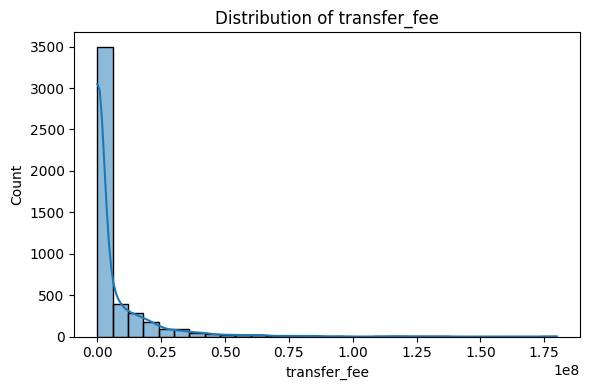

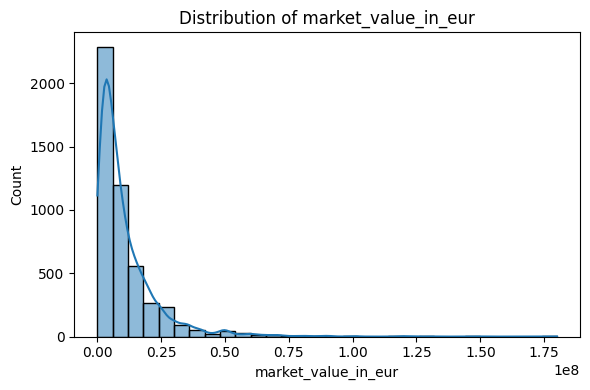

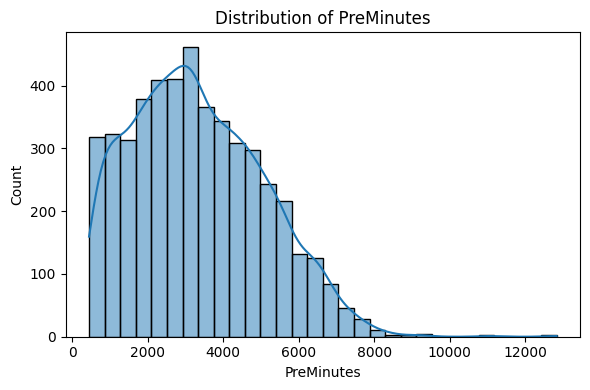

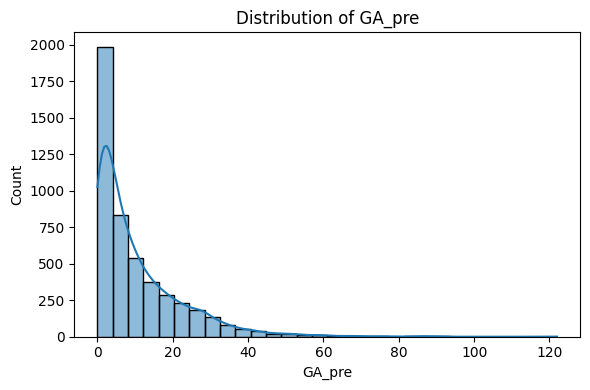

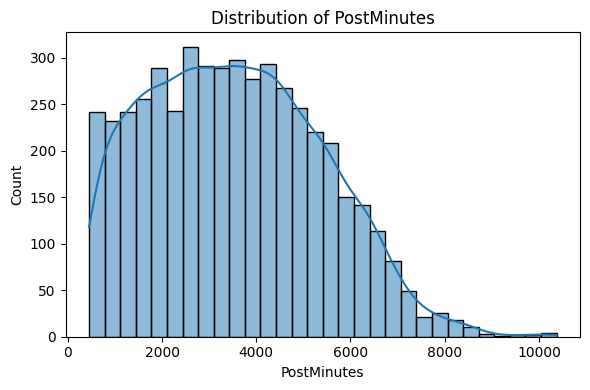

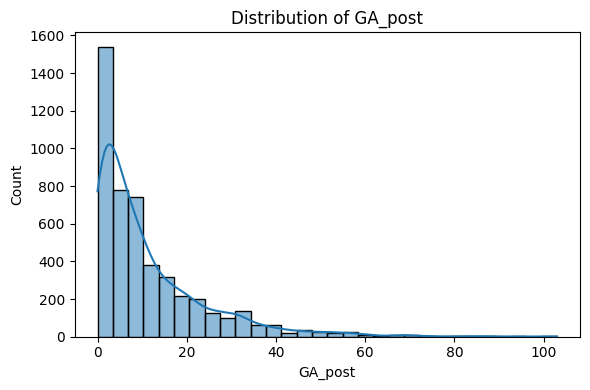

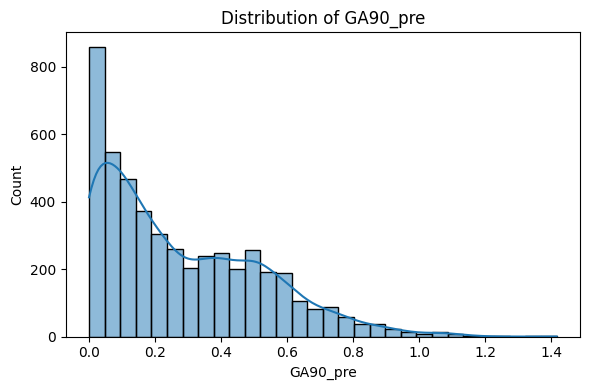

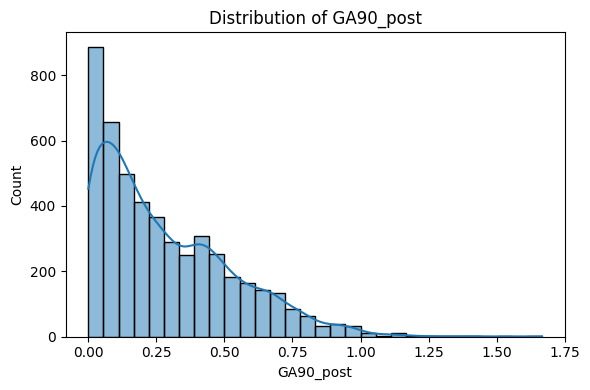

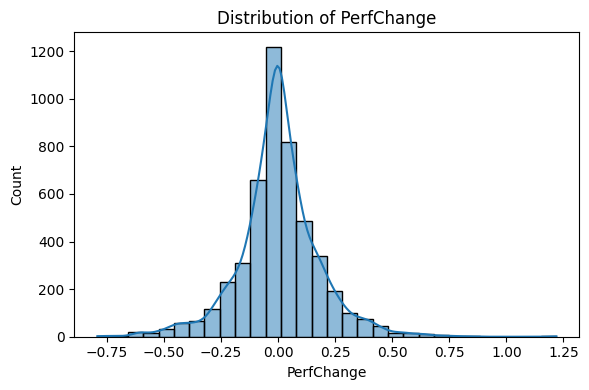

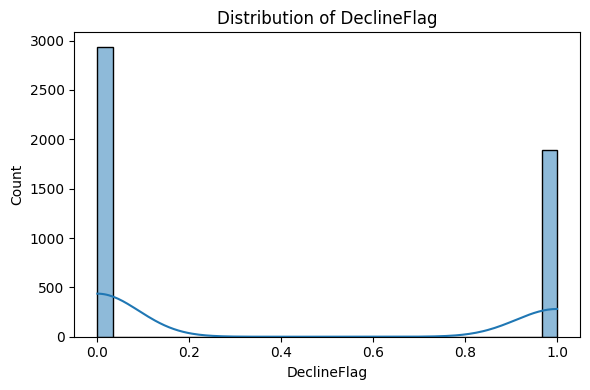

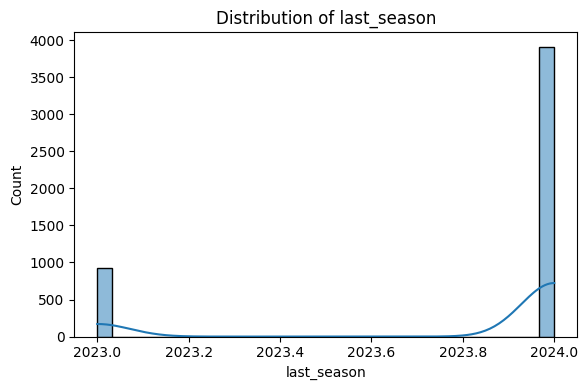

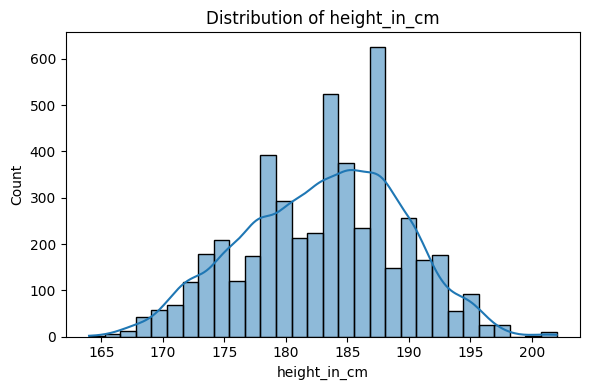

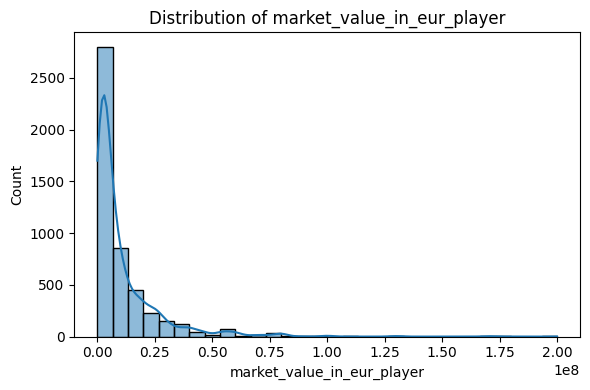

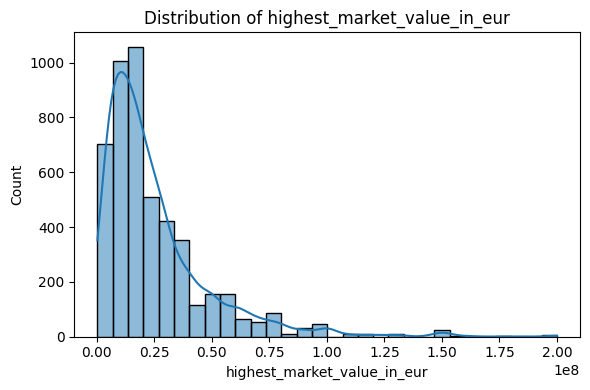

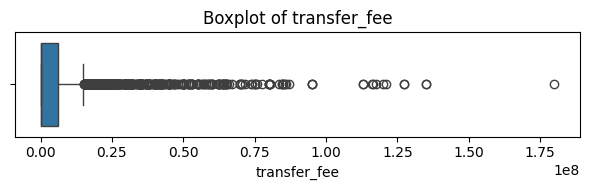

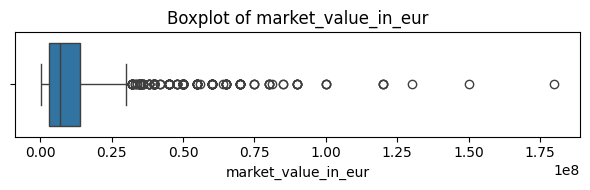

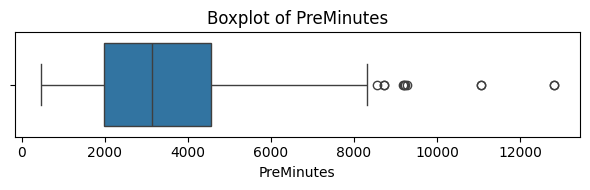

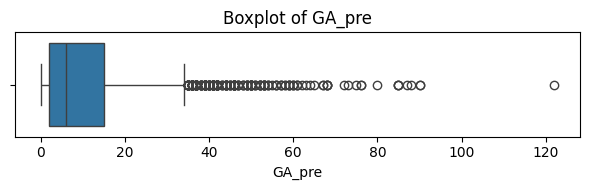

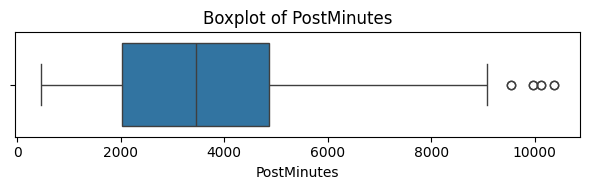

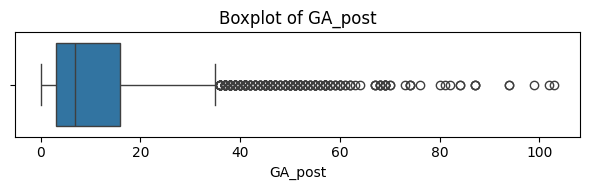

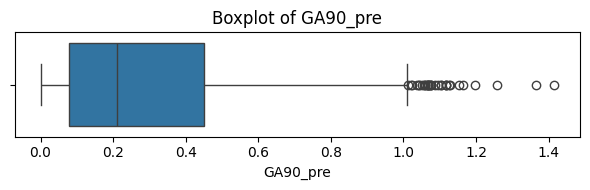

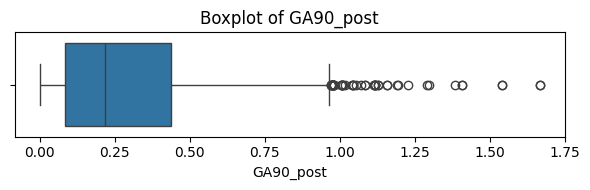

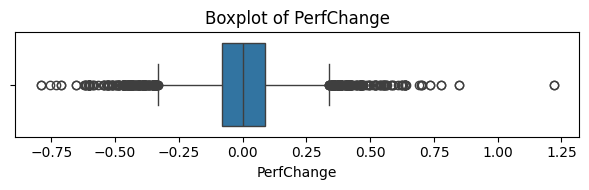

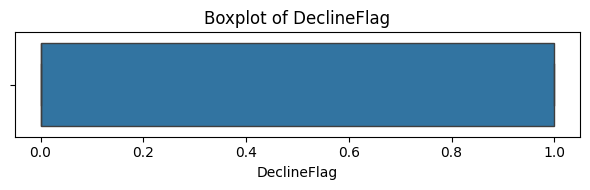

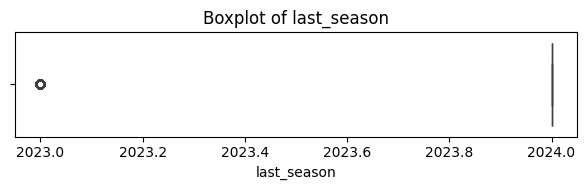

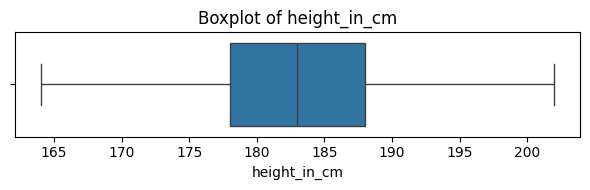

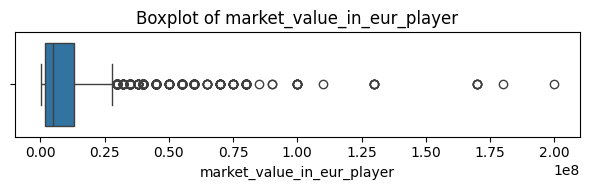

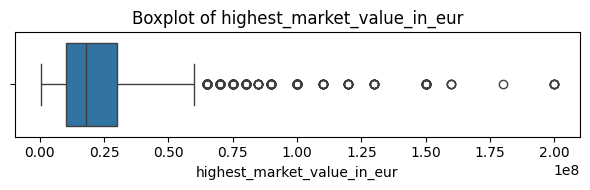

In [14]:
import os

# Create results folder
os.makedirs("../results/eda", exist_ok=True)

# Numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude ID-like columns (anything containing 'id' in its name)
numeric_cols = [c for c in numeric_cols if "id" not in c.lower()]

print("Numeric columns (excluding IDs):", numeric_cols)

# Histograms + KDE for all numeric features
for col in numeric_cols:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True, bins=30, ax=ax)
    ax.set_title(f"Distribution of {col}")
    plt.tight_layout()
    fig.savefig(f"../results/eda/hist_{col}.png")  # save first
    plt.show()  # then show
    plt.close(fig)

# Boxplots for all numeric features
for col in numeric_cols:
    fig, ax = plt.subplots(figsize=(6,2))
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Boxplot of {col}")
    plt.tight_layout()
    fig.savefig(f"../results/eda/box_{col}.png")  # save first
    plt.show()  # then show
    plt.close(fig)

## Check for Missing Data

Missing counts:
 agent_name                  1170
contract_expiration_date     302
first_name                   300
from_league                  212
from_league_name             212
from_club_name               212
to_club_name                 165
to_league                    165
to_league_name               165
transfer_fee                 123
dtype: int64

Missing percentages:
 agent_name                  24.228619
contract_expiration_date     6.253883
first_name                   6.212466
from_league                  4.390143
from_league_name             4.390143
from_club_name               4.390143
to_club_name                 3.416856
to_league                    3.416856
to_league_name               3.416856
transfer_fee                 2.547111
dtype: float64


c:\Users\Pouya\AppData\Local\Programs\Python\Python310\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


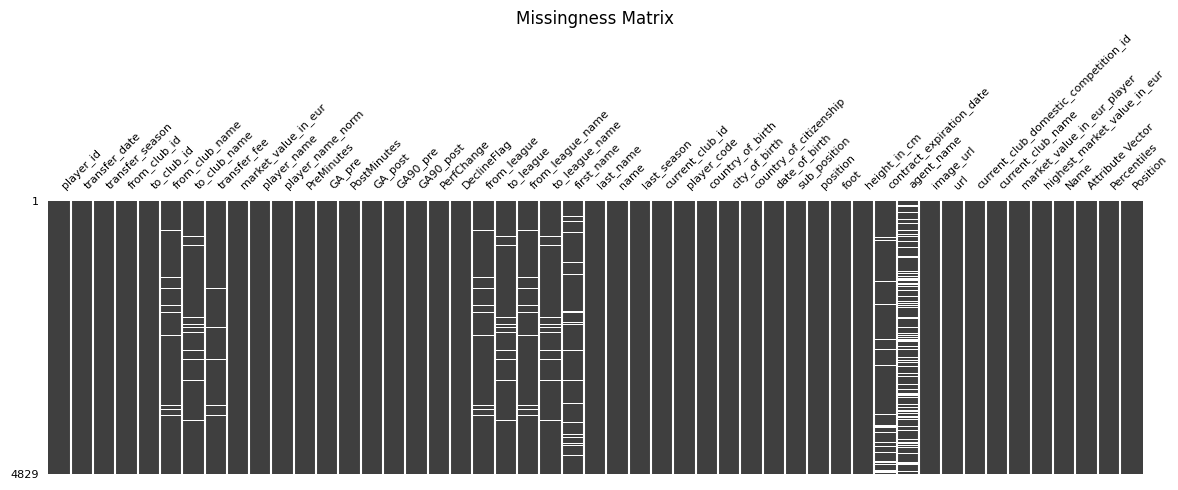

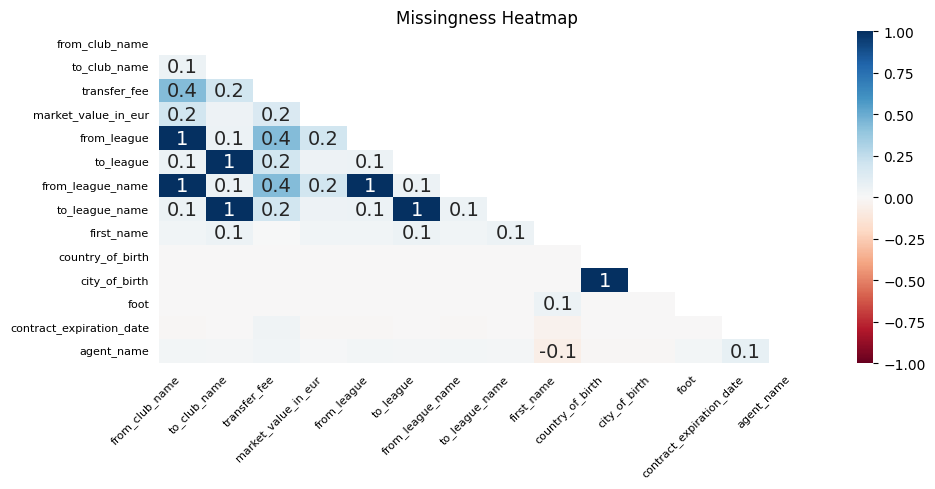

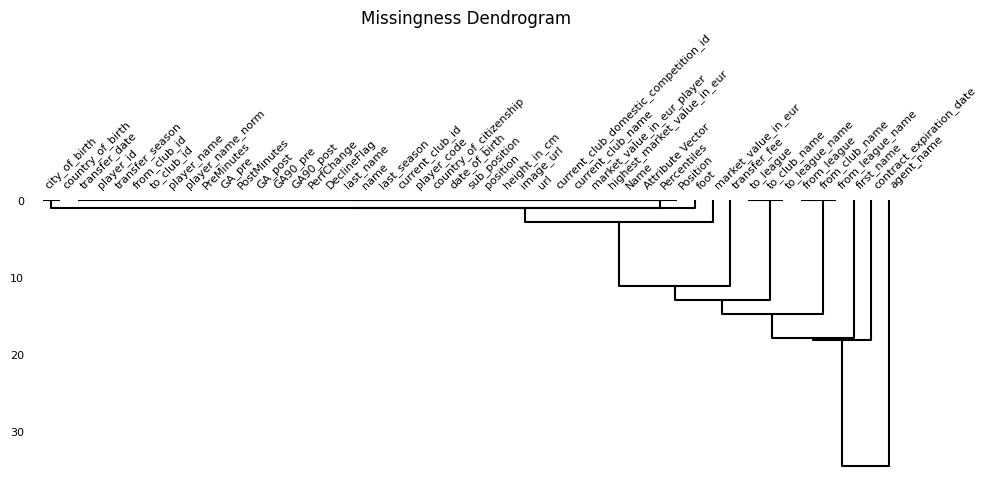

In [16]:
# Missing counts + percentages
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_perc   = (df.isna().mean() * 100).sort_values(ascending=False)

print("Missing counts:\n", missing_counts.head(10))
print("\nMissing percentages:\n", missing_perc.head(10))

# Save missing counts and percentages to CSV for reference
missing_summary = pd.DataFrame({"count": missing_counts, "percent": missing_perc})
missing_summary.to_csv("../results/eda/missing_summary.csv")

# Missingness visualizations with adjusted sizes
fig, ax = plt.subplots(figsize=(12,5))  # larger figure
msno.matrix(df, ax=ax)
ax.set_title("Missingness Matrix", fontsize=12)
plt.xticks(rotation=45, fontsize=8)  # smaller tick labels
plt.yticks(fontsize=8)
plt.tight_layout()
fig.savefig("../results/eda/missing_matrix.png", dpi=150)
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(10,5))
msno.heatmap(df, ax=ax)
ax.set_title("Missingness Heatmap", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
fig.savefig("../results/eda/missing_heatmap.png", dpi=150)
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(10,5))
msno.dendrogram(df, ax=ax)
ax.set_title("Missingness Dendrogram", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
fig.savefig("../results/eda/missing_dendrogram.png", dpi=150)
plt.show()
plt.close(fig)

## Relationships Between Variables

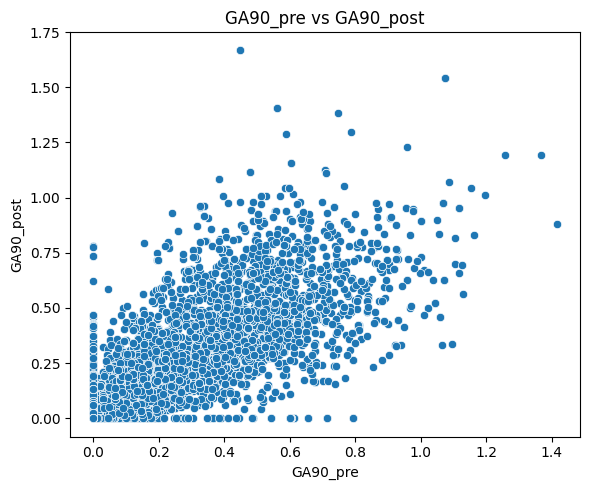

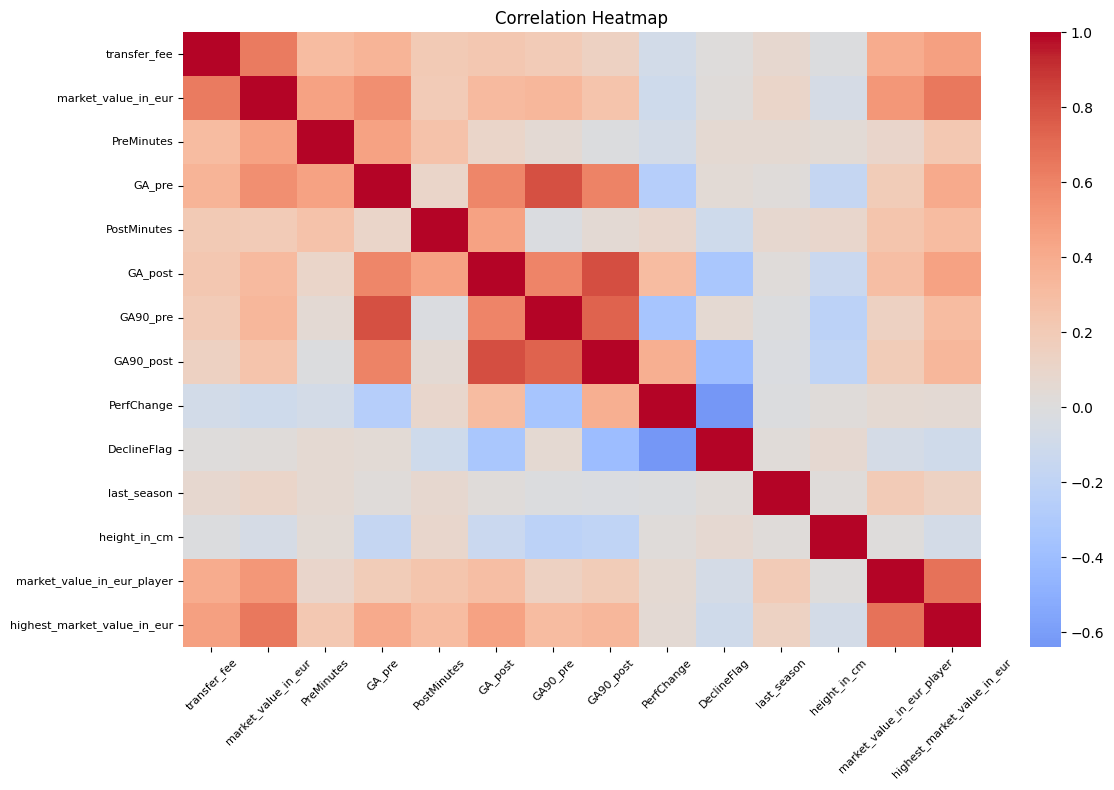

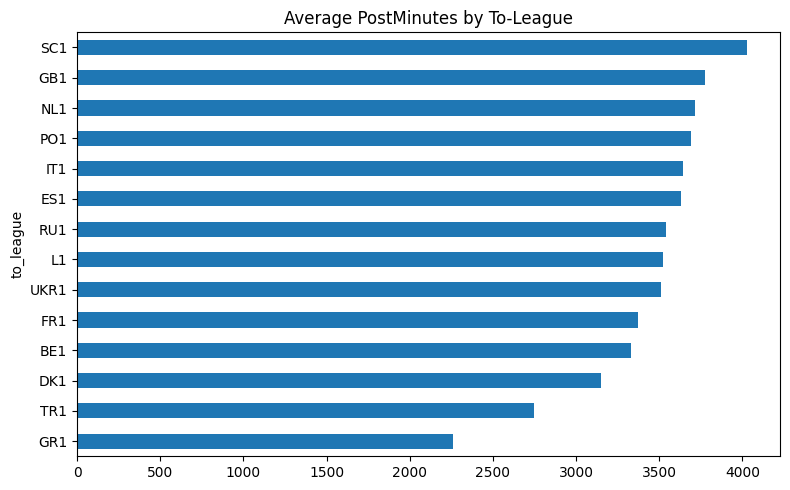

In [17]:
# Scatterplot: GA90_pre vs GA90_post
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(x="GA90_pre", y="GA90_post", data=df, ax=ax)
ax.set_title("GA90_pre vs GA90_post", fontsize=12)
plt.tight_layout()
fig.savefig("../results/eda/scatter_GA90_pre_post.png", dpi=150)
plt.show()
plt.close(fig)

# Correlation heatmap
fig, ax = plt.subplots(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, ax=ax)
ax.set_title("Correlation Heatmap", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
fig.savefig("../results/eda/corr_heatmap.png", dpi=150)
plt.show()
plt.close(fig)

# Group summary: mean PostMinutes by To-League
fig, ax = plt.subplots(figsize=(8,5))
df.groupby("to_league")["PostMinutes"].mean().sort_values().plot(kind="barh", ax=ax)
ax.set_title("Average PostMinutes by To-League", fontsize=12)
plt.tight_layout()
fig.savefig("../results/eda/group_PostMinutes_by_league.png", dpi=150)
plt.show()
plt.close(fig)

## Outlier Detection

In [18]:
df[numeric_cols].columns

Index(['transfer_fee', 'market_value_in_eur', 'PreMinutes', 'GA_pre', 'PostMinutes', 'GA_post', 'GA90_pre', 'GA90_post', 'PerfChange', 'DeclineFlag',
       'last_season', 'height_in_cm', 'market_value_in_eur_player', 'highest_market_value_in_eur'],
      dtype='object')

Outlier counts per feature (Z>3):
transfer_fee                   106
market_value_in_eur            118
PreMinutes                       9
GA_pre                          81
PostMinutes                      9
GA_post                        102
GA90_pre                        34
GA90_post                       29
PerfChange                      67
DeclineFlag                      0
last_season                      0
height_in_cm                     0
market_value_in_eur_player     113
highest_market_value_in_eur    102
dtype: int64


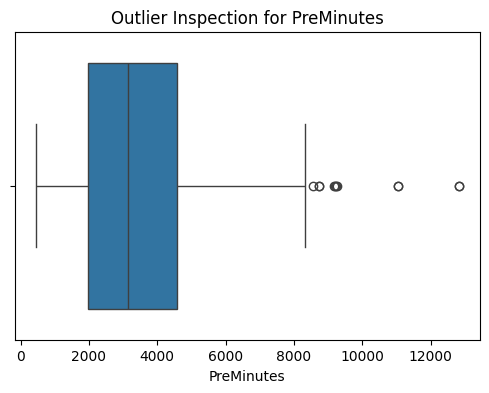

In [19]:
# Z-score based outlier detection for one variable
z_scores = zscore(df[numeric_cols].dropna())
abs_z = np.abs(z_scores)
outliers = (abs_z > 3).sum(axis=0)
print("Outlier counts per feature (Z>3):")
print(outliers)

# Isolation Forest (multivariate outlier detection)
iso = IsolationForest(contamination=0.05, random_state=42)
df["outlier_flag"] = iso.fit_predict(df[numeric_cols].fillna(0))
df["outlier_flag"].value_counts()

# Boxplot highlighting outliers for GA90_pre
plt.figure(figsize=(6,4))
sns.boxplot(x=df["PreMinutes"])
plt.title("Outlier Inspection for PreMinutes")
plt.show()

## Time-Series and Lag Structure

In [20]:
df["transfer_date"]

0       2025-02-07
1       2025-02-04
2       2025-02-03
3       2025-02-03
4       2025-02-03
           ...    
4824    2013-01-21
4825    2013-01-03
4826    2013-01-03
4827    2013-01-02
4828    2013-01-02
Name: transfer_date, Length: 4829, dtype: object

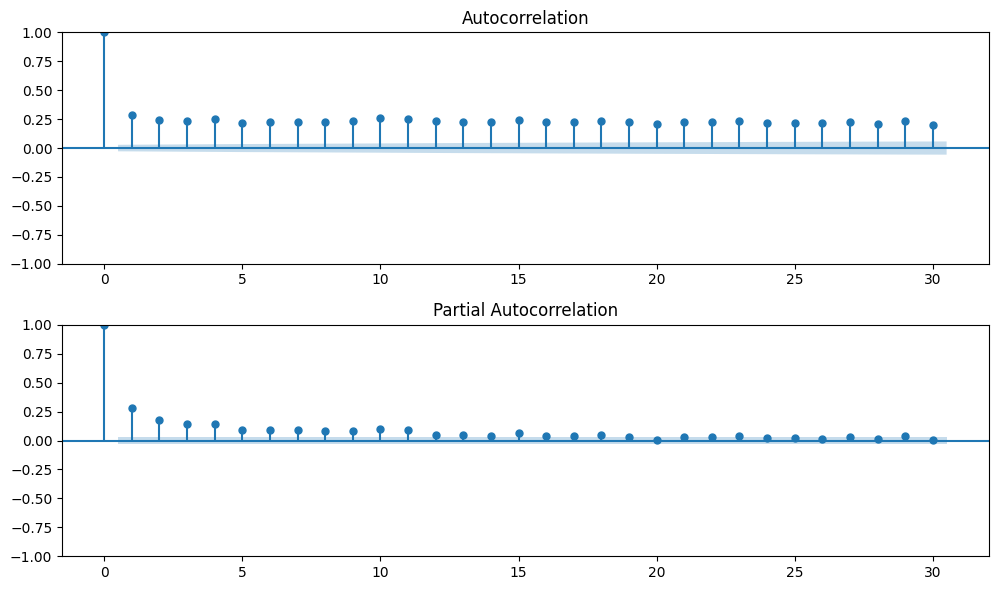

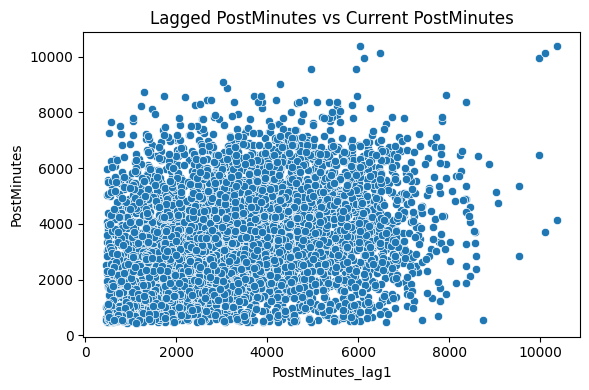

In [25]:
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Convert transfer_date to datetime
df["transfer_date"] = pd.to_datetime(df["transfer_date"], errors="coerce")

# Sort by time
df = df.sort_values("transfer_date")

# --- Time series: GA90_post over time (Plotly) ---
fig = px.line(df, x="transfer_date", y="GA90_post", title="GA90_post over Time")
fig.write_html("../results/eda/timeseries_GA90_post.html")
fig.show()

# --- Lag feature for PostMinutes ---
df["PostMinutes_lag1"] = df["PostMinutes"].shift(1)

# --- Autocorrelation and Partial Autocorrelation ---
fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(df["PostMinutes"].dropna(), ax=ax[0], lags=30)
plot_pacf(df["PostMinutes"].dropna(), ax=ax[1], lags=30)
plt.tight_layout()
fig.savefig("../results/eda/acf_pacf_PostMinutes.png", dpi=150)
plt.show()
plt.close(fig)

# --- Lag-target scatterplot ---
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=df["PostMinutes_lag1"], y=df["PostMinutes"], ax=ax)
ax.set_title("Lagged PostMinutes vs Current PostMinutes", fontsize=12)
plt.tight_layout()
fig.savefig("../results/eda/lag_scatter_PostMinutes.png", dpi=150)
plt.show()
plt.close(fig)